In [1]:
%load_ext autoreload
%autoreload 2

**Installing necessary packages**

In [2]:
import shutil
import glob
import os
from multiprocessing.pool import ThreadPool
# from tqdm.notebook import tqdm # TODO ask Kristin to add?

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy import wcs
from astropy.io import fits
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.visualization import astropy_mpl_style, ImageNormalize, ZScaleInterval, PercentileInterval, AsinhStretch, SqrtStretch, SquaredStretch
plt.style.use(astropy_mpl_style)
pd.set_option('display.max_colwidth', 0) #to show full column content (no wrapping and no dots)

# datalabs only
from astroquery.esa.euclid.core import EuclidClass, Euclid

/tmp/ipykernel_973/479455685.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
import morphology_utils
import cutout_utils
import pipeline_utils

**Logging in**

In [26]:
# change to your username
Euclid.login(user='mwalms01')

INFO: Login to Euclid TAP server [astroquery.esa.euclid.core]


Password:  ········


INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid data service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid cutout service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]


## Get list of all tiles in a survey

INFO: Query finished. [astroquery.utils.tap.core]
Found 3494  query results


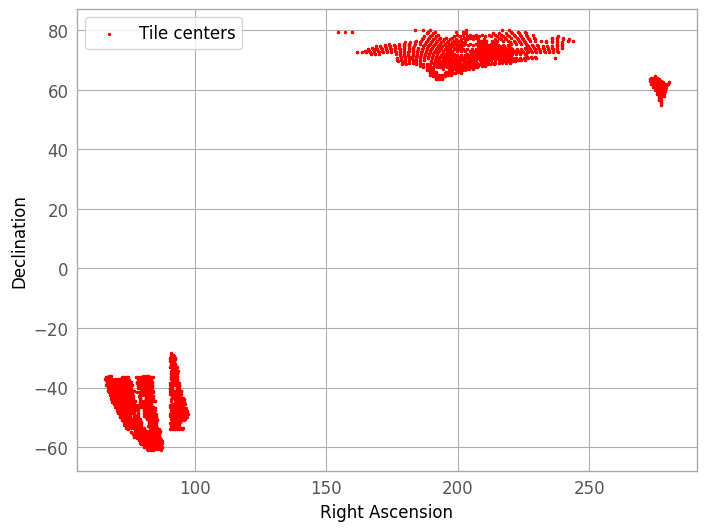

## Testing mode

Download each tile, get sources for that tile, make cutouts for that tile, move on

In [17]:
    
# for tile_n, tile in tiles_with_extents[:4].iterrows():
#     print(tile_n, tile['tile_index'])
#     tile_galaxies = pipeline_utils.find_zoobot_sources_in_tile(tile, segmentation_area)
    
#     vis_loc, nisp_loc = pipeline_utils.download_mosaics(tile['tile_index'], tiles, download_dir)

#     pipeline_utils.save_cutouts(cutout_folder, vis_loc, nisp_loc, tile_galaxies)

## Pipeline mode

Download a bunch of tiles and source catalogs while the connection is alive, then make cutouts overnight

In [18]:
pd.unique(tiles_with_extents['tile_index'])

array([102010567, 102010568, 102010569, ..., 102042982, 102042983,
       102043616])

0 102034406
1 102033246
2 102012403
3 102026099
4 102041725
5 102025576
6 102030997
7 102026098
8 102019633
9 102032104
10 102022988
11 102022015
12 102015615
13 102030972
14 102029879
15 102022002
16 102036819
17 102030421
18 102013176
19 102019169
20 102025037
21 102012400
22 102042351
23 102030405
24 102027675
25 102032117
26 102028213
27 102030968
28 102025555
29 102032096
30 102025555
31 102028213
32 102021057
33 102023521
34 102026063
35 102026083
36 102033263
37 102033849
38 102013966
39 102025020
40 102019150
41 102028782
42 102031550
43 102015620
44 102034444
45 102020090
46 102017361
47 102021061
48 102028781
49 102021034
50 102017336
51 102016463
52 102020561
53 102030408
54 102016896
55 102013571
56 102028760
57 102027661
58 102032115
59 102021041
60 102022013
61 102016036
62 102020561
63 102017360
64 102022017
65 102024506
66 102028215
67 102027667
68 102023993
69 102032685
70 102027664
71 102012787
72 102022027
73 102031525
74 102028753
75 102016054
76 102022990
77 102028

ERROR: Query failed: SELECT object_id, right_ascension, declination, gaia_id, segmentation_area, flux_segmentation, flux_vis_aper, ellipticity, kron_radius, flag_vis, flag_y
                FROM catalogue.mer_catalogue
                WHERE flux_vis_aper > 0
                AND gaia_id IS NULL
                AND vis_det=1
                AND spurious_prob < 0.2
                AND (segmentation_area > 1200 OR flux_segmentation > 22.90867652)
                AND right_ascension > 76.58293208413679 AND right_ascension < 77.37634099165075
                AND declination > -47.76595355316967 AND declination < -47.232664360406275
                ORDER BY object_id ASC
                : 
 Server unable to fulfill a bad request [astroquery.esa.euclid.core]


UnboundLocalError: local variable 'df' referenced before assignment

In [84]:
# pipeline_utils.find_zoobot_sources_in_tile(vis_tile)

In [114]:
# quick check
catalog_locs = glob.glob(base_catalog_dir + '/*_mer_catalog.csv')
print(f'Found {len(catalog_locs)} catalogs')
master_catalog = pd.concat([pd.read_csv(c) for c in catalog_locs], axis=0)
print(f'Found {len(master_catalog)} sources')

# TODO apply any galaxy-level random subselection?
# nah, I think tile-level subselection will be enough. It's clearer to do every relevant source in a given tile. Then we have a list of classified tiles.

master_catalog['jpg_loc_composite'] = master_catalog.apply(
    lambda x: pipeline_utils.get_cutout_loc(cutout_folder, x, output_format='jpg', version_suffix='composite', oneway_hash=False), axis=1)
master_catalog['jpg_loc_vis_only'] = master_catalog.apply(
    lambda x: pipeline_utils.get_cutout_loc(cutout_folder, x, output_format='jpg', version_suffix='vis_only', oneway_hash=False), axis=1)
master_catalog['jpg_loc_vis_lsb'] = master_catalog.apply(
    lambda x: pipeline_utils.get_cutout_loc(cutout_folder, x, output_format='jpg', version_suffix='vis_lsb', oneway_hash=False), axis=1)
                                                           

master_catalog.to_csv(base_catalog_dir + '/_master_catalog.csv', index=False)  # _ to appear first

Found 94 catalogs
Found 82630 sources


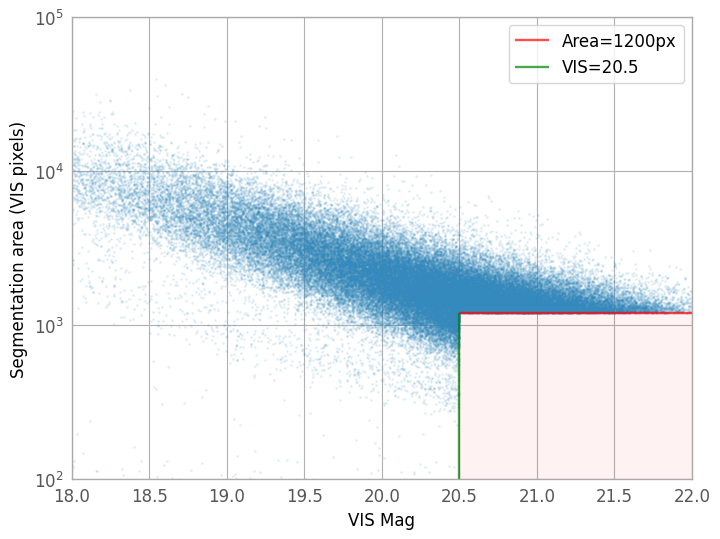

In [115]:

fig, ax = plt.subplots()
ax.scatter(master_catalog['mag_segmentation'], master_catalog['segmentation_area'], alpha=.1, s=1.)
ax.set_yscale('log')
plt.xlabel('VIS Mag')
plt.ylabel('Segmentation area (VIS pixels)')
x_min = 18
x_max = 22
y_min = 10**2
y_max = 10**5
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.hlines(1200, 20.5, x_max, linestyle='-', alpha=.7, color='r', label='Area=1200px')
ax.vlines(20.5, y_min, 1200, linestyle='-', alpha=.7, color='g', label='VIS=20.5')

alpha = .05
color = 'r'
select_x = np.linspace(x_min, x_max)

select_x = np.linspace(20.5, x_max)
ax.fill_between(select_x, y_min, 1200, color=color, alpha=alpha)
# ax.text(19.1, 400, 'Complete to VIS=20.5')
# ax.text(20.1, 5000, 'Includes faint extended galaxies')

plt.legend(loc='upper right')

In [116]:
valid_tile_indices = list(master_catalog['tile_index'].unique())
# valid_tile_indices = [102010567]  # good tile
# valid_tile_indices = [102010923]  # good tile
# valid_tile_indices = [102010569]  # bad tile, negative X_CENTER, Y_CENTER on all sources, following up with MER
# valid_tile_indices.sort()
print(f'Tiles to make cutouts from: {len(valid_tile_indices)}')

for tile_n, tile_index in enumerate(valid_tile_indices):
    print(f'Tile {tile_index}, {tile_n}')
    tile_galaxies = master_catalog.query(f'tile_index == {tile_index}')
    print(tile_galaxies[['right_ascension', 'declination']].mean())
    vis_loc = tile_galaxies['vis_tile'].iloc[0]
    nisp_loc = tile_galaxies['y_tile'].iloc[0]
    pipeline_utils.save_cutouts(vis_loc, nisp_loc, tile_galaxies, overwrite=False)

Tiles to make cutouts from: 94
Tile 102034406, 0
right_ascension    67.571114
declination       -36.015303
dtype: float64
loading tile


KeyboardInterrupt: 

In [ ]:
valid_tile_indices

In [89]:
# cutout_folder.replace('jpg', 'fits')

In [90]:
# also save the cutouts as FITS, for other people to tinker with 
# much more space-expensive, but still a lot smaller than the original tiles

# TODO Kristin, could you help me save the coordinates of the cutout in the cutout fits headers? I have the tile WCS but need to adapt it post-tile-slice for each cutout

# valid_tile_indices = [102010567]
# for tile_n, tile_index in enumerate(valid_tile_indices):
#     print(f'Tile {tile_index}, {tile_n}')
#     tile_galaxies = master_catalog.query(f'tile_index == {tile_index}')[:50]
#     vis_loc = tile_galaxies['vis_tile'].iloc[0]
#     nisp_loc = tile_galaxies['y_tile'].iloc[0]
#     pipeline_utils.save_cutouts(cutout_folder.replace('jpg', 'fits'), vis_loc, nisp_loc, tile_galaxies, overwrite=True, output_format='fits.gz')

In [91]:
# example_vis, header_vis = fits.getdata('/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/cutouts/fits/102010567/102010567_NEG824834966608550243.fits.gz', ext=1, header=True)
# example_y, header_y = fits.getdata('/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/cutouts/fits/102010567/102010567_NEG824834966608550243.fits.gz', ext=2, header=True)
# example_vis.shape, example_y.shape

In [92]:
# fig, axes = plt.subplots(ncols=2)
# axes[0].imshow(np.arcsinh(example_vis * 100))
# axes[1].imshow(np.arcsinh(example_y * 0.2))

In [93]:
# header_vis

In [ ]:
# header_y

In [ ]:
# cutout_folder

## Package for Export

In [ ]:
# # only zip one tile of fits, quite big
# shutil.make_archive(
#     '/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/fits_cutouts', 
#     'zip', 
#     '/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/cutouts/fits/102010567'
# )

In [94]:
cutout_folder

'/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/v2_challenge_launch/cutouts/jpg'

In [ ]:
!du -sh $cutout_folder/*

In [ ]:
# !du -sh $cutout_folder

In [95]:
# save to e.g. v1_challenge_launch_cutouts.zip
shutil.make_archive(download_dir + '_cutouts', 'zip', root_dir=cutout_folder)  # should be jpg only



'/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/v2_challenge_launch_cutouts.zip'

In [96]:
base_catalog_dir

'/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/v2_challenge_launch/catalogs'

In [117]:
shutil.make_archive(download_dir + '_catalogs', 'zip', base_catalog_dir)

'/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/v2_challenge_launch_catalogs.zip'